In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

## CV2 Click Event
Sending Params containing Counter and number of Points taken 

In [2]:
def click_event(event, x, y, flags, params):
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x, ' ', y)
        params[2].append((x,y))
#         cv2.imshow('image', img)
    if event == cv2.EVENT_LBUTTONUP:
        params[0]+=1
    if params[0] >= params[1]:
        cv2.destroyAllWindows()
        params[0] = 0

# Reading Image using Cv2 then calling Mouse Event

In [3]:
def getPoints(image1,image2,numberOfPoints):
    points = list()
    params=[0,numberOfPoints,points]
    #img = cv2.imread("image2.jpg")
    cv2.imshow('image', image1)
    cv2.setMouseCallback('image', click_event,params)
    cv2.waitKey(0)

    #img = cv2.imread("image1.jpg")
    cv2.imshow('image', image2)
    cv2.setMouseCallback('image', click_event,params)
    cv2.waitKey(0)
    return points,params;

# Filling b and A then compute H where H = inv(A.T . A) . A.T . b

In [4]:
def computeHomography(points,params):
    matrix = np.zeros((params[1]*2, 8)) ## A Matrix
    img2Matrix = np.zeros((params[1]*2,1)) ## b Matrix
    ## Seperating selected points for each view
    img1Points = points[:params[1]]
    img2Points = points[params[1]:]
    
    ## Filling b
    for index, tuple in enumerate(img2Points): 
        img2Matrix[index] = tuple[0]
        img2Matrix[index+params[1]] = tuple[1]
    ## Filling A
    for index, tuple in enumerate(img1Points):
        x=0
        y=0
        
        for j in range(8):
            if j < 2 and index < params[1]:
                matrix[index][j] = tuple[x]
                x+=1
            if j == 2 and index < params[1]:
                matrix[index][j] = 1
            if j > 5  and index < params[1]:
                matrix[index][j] = -(tuple[y]*img2Matrix[index])
                y+=1

    i = params[1]       
    for index,tuple in enumerate(img1Points):
        x = 0
        y = 0
        for j in range(8):
            if j > 2 and j < 5 :
                matrix[i][j] = tuple[x]
                x+=1
            if j == 5:
                matrix[i][j] = 1
            if j > 5 :
                matrix[i][j] = -(tuple[y]*img2Matrix[i])
                y+=1
        i+=1
    matrix = np.array(matrix)
    img2Matrix = np.array(img2Matrix)
    ## Using Least Square Solution
    inverseMatrix = np.dot(np.linalg.inv(np.dot(matrix.T,matrix)),matrix.T) 
    homography = np.dot(inverseMatrix,img2Matrix) ## Computing Homography Matrix
    homography = np.insert(homography,8,1,axis=0) ## Inserting h33 = 1
    homography = homography.reshape(3,3) ## Reshape Homography from 9x1 to 3x3
    return homography; 

# Get correspondence points from image 1 to image 2 (forward warping)

In [5]:
def getCorrespondence(image,H):
    #img = cv2.imread("image2.jpg")
    h,w = image.shape[:2]
    xPoints = []
    yPoints = []
    ##Forward Warping
    for y in range(h): ## rows
        for x in range(w): ## columns 
            point = np.array([[x,y,1]])
            newPoint = np.dot(H,point.T)
            lamd = newPoint[2]
            newPoint = newPoint/lamd
            xPoints.append(newPoint[0][0])
            yPoints.append(newPoint[1][0])
    xPoints = np.array(xPoints)
    yPoints = np.array(yPoints)
    return xPoints,yPoints;
         

In [6]:
def warping(xPoints_dash,yPoints_dash,H,image,inverseWarp = 0):
    ## Checking if there is -ve Points then add the minimum -ve value to all co-ordinate points
    ## else do nothing
    h,w = image.shape[:2]
    new_Xpoints_dash = xPoints_dash.copy()
    new_Ypoints_dash = yPoints_dash.copy()
    minX = np.amin(xPoints_dash)
    minY = np.amin(yPoints_dash)
    maxX = np.amax(xPoints_dash)
    maxY = np.amax(yPoints_dash)
    if(minY < 0):
        newH = int(maxY-minY)
        new_Ypoints_dash += -minY
    else:
        minY=0
        newH = h

    if(minX < 0):
        newW = int(maxX-minX)
        new_Xpoints_dash += -minX
    else:
        minX=0
        newW = w
        
    ##shifting points to a new location in a new image
    forwardWarp_image = np.zeros((newH,newW,3), np.uint8)
    i = 0;
    for y_src in range(h):
        for x_src in range(w):
            if (int(new_Ypoints_dash[i]) < newH) and int(new_Xpoints_dash[i]) < newW:
                forwardWarp_image[int(new_Ypoints_dash[i]),int(new_Xpoints_dash[i])] = image[y_src,x_src]
            i+=1
    inverseWarp_image = forwardWarp_image.copy()
    if inverseWarp:
        h,w = forwardWarp_image.shape[:2]
        ## Inverse Warping
        for y in range(h):
            for x in range(w):
                
                point = np.array([[x+minX,y+minY,1]])
                revPoint = np.dot(np.linalg.inv(H),point.T)
                lamd = revPoint[2]
                revPoint = revPoint/lamd
                pointX = revPoint[0][0] 
                pointY = revPoint[1][0]
                if(pointX < 0 or pointY < 0):
                     continue;
                # Bilinear Interpolation
                pointX_ceil = math.ceil(pointX)
                pointX_floor = math.floor(pointX)
                pointY_ceil = math.ceil(pointY)
                pointY_floor = math.floor(pointY)          
                matX = np.array([[pointX_ceil-pointX,pointX-pointX_floor]])
                try:
                    matF = np.array([[image[pointY_floor,pointX_floor], image[pointY_ceil,pointX_floor]],[image[pointY_floor,pointX_ceil],image[pointY_ceil,pointX_ceil]]])
                except:
                    pass
                matY = np.array([[pointY_ceil-pointY,pointY-pointY_floor]])
                div =  matX / ((pointX_ceil-pointX_floor)*(pointY_ceil-pointY_floor))
                ## Getting each channel separately
                b =  np.dot(np.dot(matX,matF)[:,:,0],matY.T)
                g =  np.dot(np.dot(matX,matF)[:,:,1],matY.T)
                r =  np.dot(np.dot(matX,matF)[:,:,2],matY.T)
                rgb_uint8 = (np.dstack((r,g,b))).reshape(-1) ##  stack them
                inverseWarp_image[y,x] = rgb_uint8
    return inverseWarp_image,forwardWarp_image,minX,minY

In [7]:
def panoramicView(inverseWarped,image,minX,minY):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    h,w = image.shape[:2]
    finalImage = np.zeros((int(h-minY),int(w-minX),3), np.uint8)
    ## Shifting image2 with same offset of image1
    for y in range(h):
        for x in range(w):
            finalImage[int(y-minY),int(x-minX)] = image[y,x]
    h,w = inverseWarped.shape[:2]
    ## adding inverseWarped image to image2 in the final image frame
    for y in range(h):
        for x in range(w):
            finalImage[y,x] = inverseWarped[y,x]

    return finalImage;

In [50]:
test = np.array([492,255,1])
test_dash = np.dot(homography,test.T)
test_dash = test_dash/test_dash[2]
test_dash

array([134.21369705,  25.73700757,   1.        ])

In [8]:
bonus_image1 = cv2.imread("shanghai-22.png")
bonus_image2 = cv2.imread("shanghai-21.png")
bonus_image3 = cv2.imread("shanghai-23.png")
image1 = cv2.imread("image2.jpg")
image2 = cv2.imread("image1.jpg")

In [9]:
def stitch(image1,image2):
    points,params = getPoints(image1,image2,6)
    homography = computeHomography(points,params)
    xPoints_dash,yPoints_dash = getCorrespondence(image1,homography)
    inverseWarped,forwardWarped,minX,minY = warping(xPoints_dash,yPoints_dash,homography,image1,1)
    finalImage = panoramicView(inverseWarped,image2,minX,minY)
    
    plt.figure(figsize=(10,10))
    plt.subplot(3,2,1)
    plt.title("image1")
    plt.imshow(image1)

    plt.subplot(3,2,2)
    plt.title("image2")
    plt.imshow(image2)

    plt.subplot(3,2,3)
    plt.title("Forward Warped Image")
    plt.imshow(forwardWarped)

    plt.subplot(3,2,4)
    plt.title("Inverse Warped Image")
    plt.imshow(inverseWarped)

    plt.subplot(3,2,5)
    plt.title("Panoramic Image")
    plt.imshow(finalImage)
    plt.show()
    return finalImage

555   549
651   549
566   632
764   654
913   339
1004   344
93   511
192   513
98   600
300   618
466   318
547   328


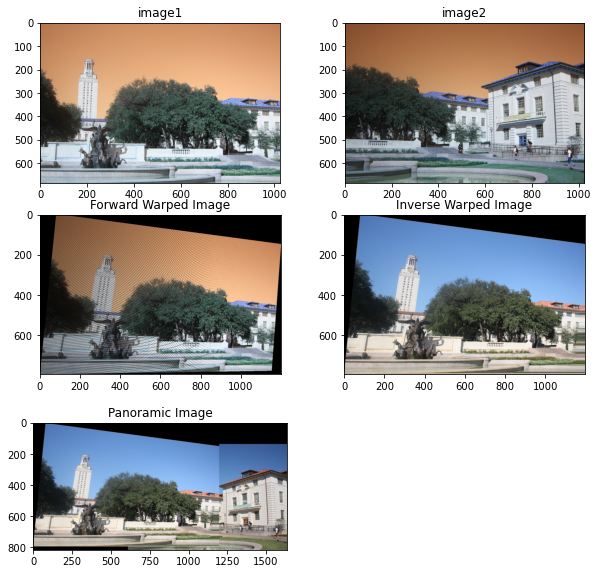

In [61]:
finalImage = stitch(image1,image2)

272   539
493   255
489   340
486   615
713   516
842   558
244   346
464   56
461   141
459   419
684   318
810   362


<ipython-input-6-66bc0cab7803>:59: RuntimeWarning: invalid value encountered in true_divide
  div =  matX / ((pointX_ceil-pointX_floor)*(pointY_ceil-pointY_floor))


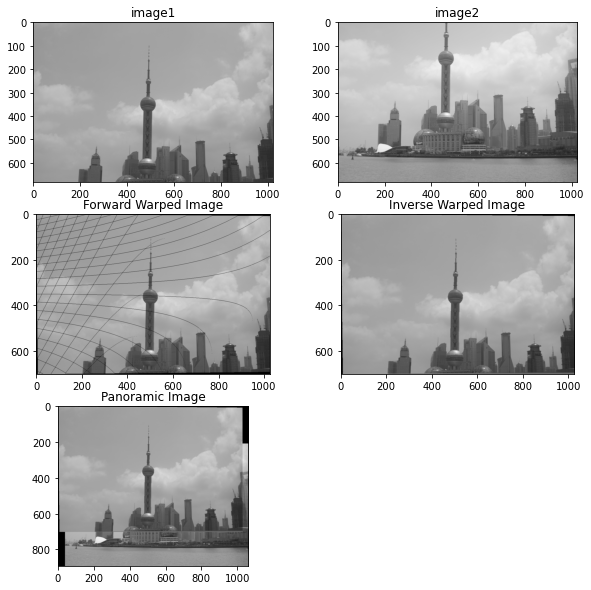

In [10]:
finalImage2 = stitch(bonus_image1,bonus_image2)

504   264
502   352
498   630
723   526
849   572
1004   521
133   26
124   116
111   398
347   306
471   355
621   314


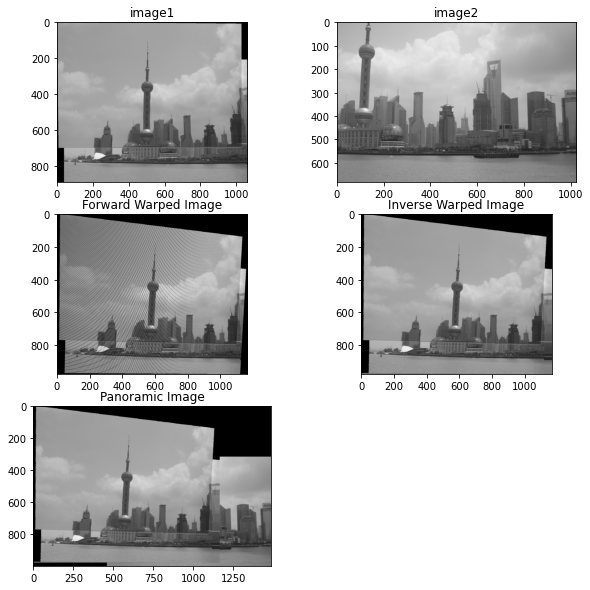

In [11]:
bonusImage = stitch(finalImage2,bonus_image3)